# Intent Detection for Banking Domain

Customer service is a vital part of the insurance business, for multiple business cases, from marketing, to customer retention and claims. By digitalizing these processes, insurers can seamlessly scale their operations and shift money and resources from operational processes to actual product and value creation.

This solutions accelerator is a head start on developing and deploying a machine learning solution to detect customer intents based on pieces of text from an Interactive Voice Response (IVR) stream or from a virtual agent.

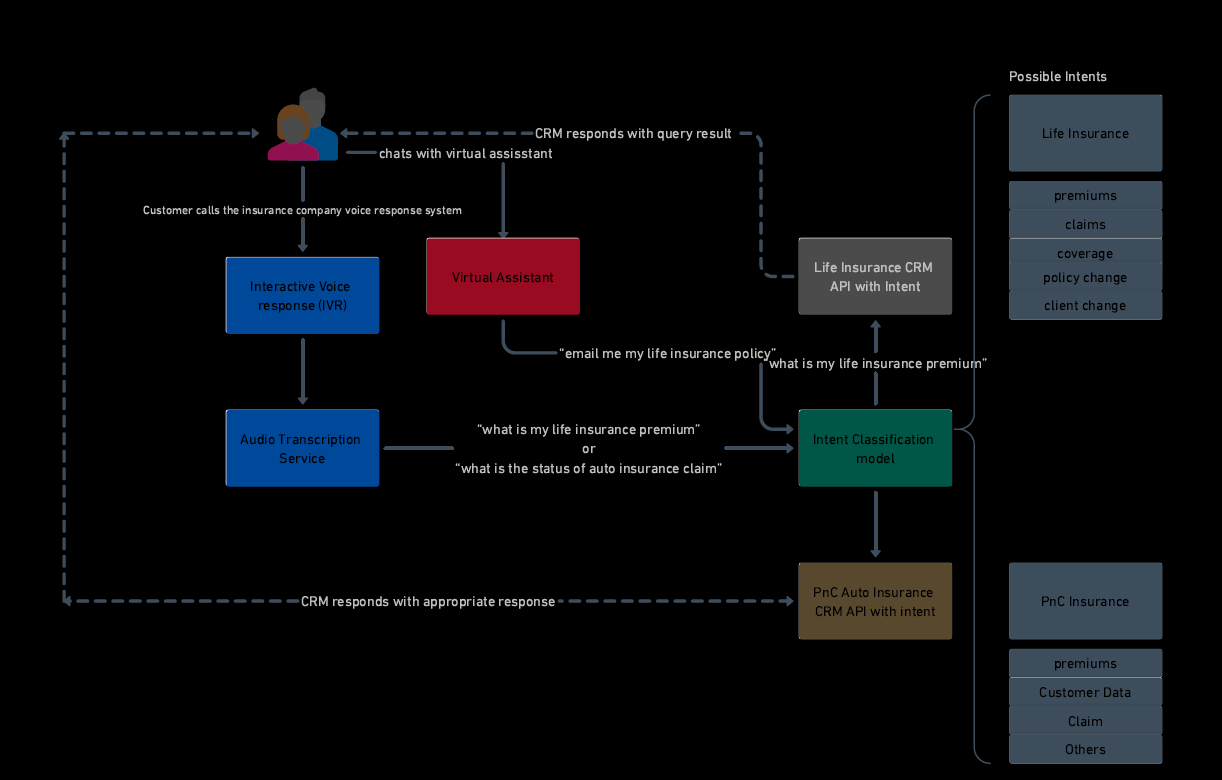

In [1]:
# Python Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path


# Data Science Libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score

# Deep learning Framework
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torch.quantization import quantize_dynamic
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import Trainer, TrainingArguments

# Datasets
from datasets import load_dataset, load_metric, Dataset

# Miscalleaneous
import warnings
warnings.filterwarnings('ignore')
device



device(type='cuda')

## Loading the Dataset and EDA

In [2]:
banking77 = load_dataset("csv", data_files = { "train" : "D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\train.csv", 
                                              "test" : "D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\test.csv"})
banking77_label = load_dataset("json", data_files = "D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\categories.json")

In [3]:
banking77["label"] = banking77_label["train"]

In [4]:
banking77

DatasetDict({
    train: Dataset({
        features: ['text', 'category'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'category'],
        num_rows: 3080
    })
    label: Dataset({
        features: ['text'],
        num_rows: 77
    })
})

* dataset has 10,000 records in train split and 3080 in test split

In [5]:
train_ds = banking77["train"]
train_ds

Dataset({
    features: ['text', 'category'],
    num_rows: 10003
})

In [6]:
train_ds["text"][500]

'Why is the exchange rate different from what I expected?'

In [7]:
train_ds["category"][500]

'card_payment_wrong_exchange_rate'

In [8]:
train_df = train_ds.to_pandas()
train_df

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival
...,...,...
9998,You provide support in what countries?,country_support
9999,What countries are you supporting?,country_support
10000,What countries are getting support?,country_support
10001,Are cards available in the EU?,country_support


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10003 entries, 0 to 10002
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      10003 non-null  object
 1   category  10003 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [10]:
train_df["category"].nunique()

77

* there are 77 different type of categories in the dataset

In [11]:
# # changing the labels to label_ids
# def label_int2str(row):
#     return train_ds.features["category"].int2str(row)

# train_df["label_name"] = train_df["label"].apply(label_int2str)
# train_df.iloc[500]

In [12]:
train_df.head()

,text,category
0,I am still waiting on my card?,card_arrival
1,What can I do if my card still hasn't arrived ...,card_arrival
2,I have been waiting over a week. Is the card s...,card_arrival
3,Can I track my card while it is in the process...,card_arrival
4,"How do I know if I will get my card, or if it ...",card_arrival


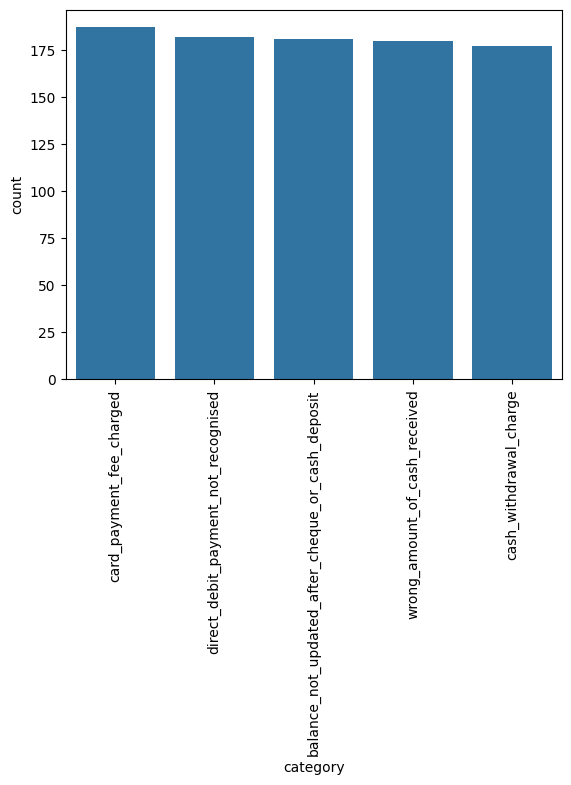

In [13]:
sns.countplot(data = train_df, x = "category", order = train_df['category'].value_counts().head(5).index)
plt.xticks(rotation=90)
plt.show()

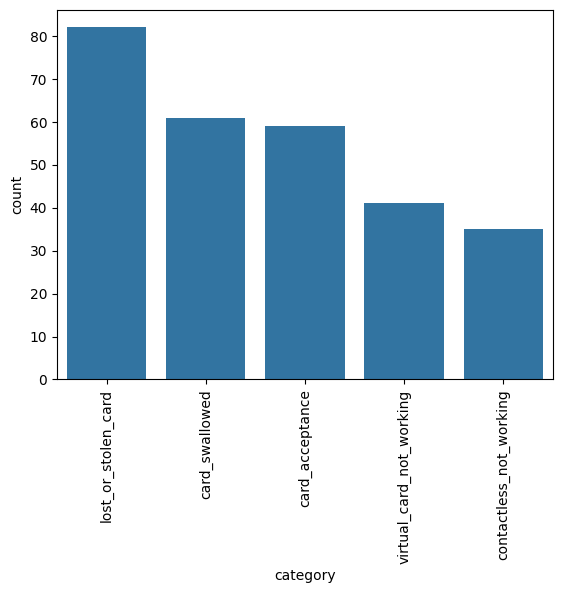

In [14]:
sns.countplot(data = train_df, x = "category", order = train_df['category'].value_counts().tail(5).index)
plt.xticks(rotation=90)
plt.show()

In [15]:
train_df["words per query"] = train_df["text"].str.split().apply(len)

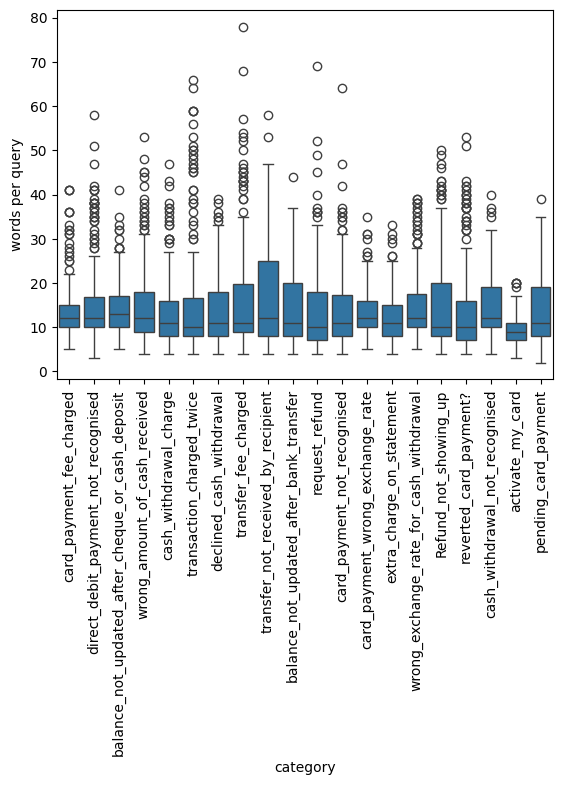

In [16]:
sns.boxplot(data = train_df, y = "words per query", x = 'category', order = train_df['category'].value_counts().head(20).index)
plt.xticks(rotation=90)
plt.show()

## Data Preprocessing

In [17]:
banking77_label_dict  = {}
for key, value in enumerate(banking77_label["train"]["text"]):
        banking77_label_dict[value] = key

train_df = banking77["train"].to_pandas()
test_df = banking77["test"].to_pandas()


In [18]:
# changing the labels to label_ids
def category2label(x):
    return banking77_label_dict[x]

train_df["category_name"] = train_df["category"].apply(category2label)
test_df["category_name"] = test_df["category"].apply(category2label)

In [19]:
train_dataset = Dataset.from_pandas(train_df[["text", "category_name"]])
test_dataset = Dataset.from_pandas(test_df[["text", "category_name"]])


# Finetuning the model with DISTILBERT Model

In [20]:
bert_ckpt = "distilbert-base-uncased"

In [21]:
tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)

In [22]:
def tokenize(batch):
    return tokenizer(batch["text"], padding = True, truncation = True, return_tensors = "pt")

In [23]:
train_dataset_encoded = train_dataset.map(tokenize, batched = True, remove_columns = ["text"])
train_dataset_encoded

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Dataset({
    features: ['category_name', 'input_ids', 'attention_mask'],
    num_rows: 10003
})

In [24]:
train_dataset_encoded = train_dataset_encoded.rename_column("category_name", "labels")
train_dataset_encoded

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 10003
})

In [25]:
test_dataset_encoded = test_dataset.map(tokenize, batched = True, remove_columns = ["text"])
test_dataset_encoded = test_dataset_encoded.rename_column("category_name", "labels")

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [26]:
num_labels = 77
model = AutoModelForSequenceClassification.from_pretrained(bert_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define Metrics

In [27]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average= "weighted")
    acc = accuracy_score(labels, preds)
    return {"f1" : f1, "accuracy" : acc}

## Traning the Model

In [28]:
batch_size = 64
logging_steps = len(train_dataset)//batch_size
model_name = f"{bert_ckpt}-finetuned-banking77"
model_path = "D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model"

In [29]:
training_args = TrainingArguments(output_dir = model_path,
                                  num_train_epochs = 10,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = "epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  log_level = "error")

In [30]:
trainer = Trainer(model = model,
                  args = training_args,
                  compute_metrics = compute_metrics,
                  train_dataset = train_dataset_encoded,
                  eval_dataset = test_dataset_encoded,
                  tokenizer = tokenizer)

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,3.871600,3.173514,0.472922,0.517532
2,2.625000,2.065795,0.652263,0.694805
3,1.703700,1.357909,0.760467,0.785714
4,1.131400,0.952602,0.833411,0.844156
5,0.793300,0.725578,0.867531,0.873052
6,0.591300,0.591807,0.883411,0.888312
7,0.468500,0.517440,0.892949,0.895779
8,0.390300,0.470639,0.905694,0.906494
9,0.339500,0.445290,0.910178,0.910390
10,0.315200,0.436940,0.908458,0.908766


TrainOutput(global_step=1570, training_loss=1.2173305824304084, metrics={'train_runtime': 799.6263, 'train_samples_per_second': 125.096, 'train_steps_per_second': 1.963, 'total_flos': 2539578859567560.0, 'train_loss': 1.2173305824304084, 'epoch': 10.0})

In [32]:
model.save_pretrained("D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model")

In [33]:
tokenizer.save_pretrained("D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model")

('D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model\\tokenizer_config.json',
 'D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model\\special_tokens_map.json',
 'D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model\\vocab.txt',
 'D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model\\added_tokens.json',
 'D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model\\tokenizer.json')

## Getting the prediction and Evaluation of the model

In [35]:
preds_output = trainer.predict(test_dataset_encoded)
preds_output.metrics

{'test_loss': 0.43693962693214417,
 'test_f1': 0.9084575601702107,
 'test_accuracy': 0.9087662337662338,
 'test_runtime': 6.1133,
 'test_samples_per_second': 503.824,
 'test_steps_per_second': 8.015}

In [58]:
preds_output

PredictionOutput(predictions=array([[ 3.155531  ,  2.7894614 , -2.8022814 , ..., -2.129424  ,
        -3.0971212 , -1.0020087 ],
       [ 5.8388143 ,  1.3830811 , -3.0345802 , ..., -2.0739918 ,
        -1.9469771 , -1.3070982 ],
       [ 5.3171844 ,  1.2190237 , -2.9339178 , ..., -2.312927  ,
        -2.350099  , -1.0796027 ],
       ...,
       [-0.7895567 , -1.3269479 , -0.73247725, ..., -0.5572056 ,
        -0.5753983 ,  5.959614  ],
       [-0.6912284 , -1.3380834 , -0.6038793 , ..., -0.71176326,
        -0.6576003 ,  5.919142  ],
       [-0.34387252, -0.56646585, -1.2187135 , ..., -0.9956065 ,
        -1.367922  ,  5.358254  ]], dtype=float32), label_ids=array([ 0,  0,  0, ..., 76, 76, 76], dtype=int64), metrics={'test_loss': 0.43693962693214417, 'test_f1': 0.9084575601702107, 'test_accuracy': 0.9087662337662338, 'test_runtime': 6.1133, 'test_samples_per_second': 503.824, 'test_steps_per_second': 8.015})

In [39]:
y_preds = preds_output.predictions.argmax(-1)
y_test = test_dataset["category_name"]

In [49]:
test_results = pd.DataFrame()
test_results["text"] = pd.Series(test_dataset["text"])
test_results["category_name"] = pd.Series(test_dataset["category_name"])
test_results["predicted_category"] = y_preds
test_results

,text,category_name,predicted_category
0,How do I locate my card?,0,11
1,"I still have not received my new card, I order...",0,0
2,I ordered a card but it has not arrived. Help ...,0,0
3,Is there a way to know when my card will arrive?,0,0
4,My card has not arrived yet.,0,0
...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",76,76
3076,How many countries do you support?,76,76
3077,What countries do you do business in?,76,76
3078,What are the countries you operate in.,76,76


In [52]:
banking77_label_dict_rev  = {}
for key, value in enumerate(banking77_label["train"]["text"]):
        banking77_label_dict_rev[key] = value
def label2category(x):
    return banking77_label_dict_rev[x]

test_results["actual_category_text"] = test_results["category_name"].apply(label2category)
test_results["predicted_category_text"] = test_results["predicted_category"].apply(label2category)

In [53]:
test_results

,text,category_name,predicted_category,actual_category_text,predicted_category_text
0,How do I locate my card?,0,11,card_arrival,lost_or_stolen_card
1,"I still have not received my new card, I order...",0,0,card_arrival,card_arrival
2,I ordered a card but it has not arrived. Help ...,0,0,card_arrival,card_arrival
3,Is there a way to know when my card will arrive?,0,0,card_arrival,card_arrival
4,My card has not arrived yet.,0,0,card_arrival,card_arrival
...,...,...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",76,76,country_support,country_support
3076,How many countries do you support?,76,76,country_support,country_support
3077,What countries do you do business in?,76,76,country_support,country_support
3078,What are the countries you operate in.,76,76,country_support,country_support


In [54]:
test_results[test_results["actual_category_text"] != test_results["predicted_category_text"] ]

,text,category_name,predicted_category,actual_category_text,predicted_category_text
0,How do I locate my card?,0,11,card_arrival,lost_or_stolen_card
5,When will I get my card?,0,7,card_arrival,card_delivery_estimate
11,How long does a card delivery take?,0,7,card_arrival,card_delivery_estimate
32,How do I know when my card will arrive?,0,7,card_arrival,card_delivery_estimate
37,Is there tracking info available?,0,30,card_arrival,unable_to_verify_identity
...,...,...,...,...,...
3008,I got a message that I need to verify my ident...,75,29,verify_my_identity,why_verify_identity
3020,How does my identity get verified?,75,29,verify_my_identity,why_verify_identity
3024,do the details of my profile have to match my ...,75,28,verify_my_identity,edit_personal_details
3026,"When getting my ID checked, what are the steps...",75,29,verify_my_identity,why_verify_identity


## Model Eval pipeline

In [85]:
def predict(text):
    try:
        model = AutoModelForSequenceClassification.from_pretrained("D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model")
        tokenizer = AutoTokenizer.from_pretrained("D:\\PracticeProjects\\NLP_Insurance_intent_Detection\\trained_model\\model")
        pipe = pipeline("text-classification", model = model, tokenizer = tokenizer)
        print("Query: ")
        print(text)
        category = str(pipe(text)[0]["label"]).split("_")[1]
        print(category)
        predicted_intent = label2category(int(category))
        return predicted_intent
    except Exception as e:
        return e

        

In [86]:
print(predict("When will I get my card?"))

Query: 
When will I get my card?
7
card_delivery_estimate


In [87]:
from huggingface_hub import notebook_login
model.push_to_hub(model_name, commit_message = "Training Completed")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/akashjoy/distilbert-base-uncased-finetuned-banking77/commit/53097a44fca08bee583f56761169b1d7f79d1b72', commit_message='Training Completed', commit_description='', oid='53097a44fca08bee583f56761169b1d7f79d1b72', pr_url=None, pr_revision=None, pr_num=None)

In [88]:
tokenizer.push_to_hub(model_name, commit_message = "Training Completed")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/akashjoy/distilbert-base-uncased-finetuned-banking77/commit/62222669772c74542c7270d8366e141533e065b6', commit_message='Training Completed', commit_description='', oid='62222669772c74542c7270d8366e141533e065b6', pr_url=None, pr_revision=None, pr_num=None)